In [16]:
import os
import math
import itertools
from functools import reduce
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.linalg import eigh
from scipy.sparse import identity, csr_matrix, kron, save_npz, load_npz
from k_local_hamiltonian import KLocalHamiltonian
from random_matrix_analysis import calculate_level_statistics_definition_one as cls

# matplotlib parameters 
large = 40; med = 30; small = 20
params = {'axes.titlesize': med,
          'axes.titlepad' : med,
          'legend.fontsize': med,
          'axes.labelsize': med ,
          'axes.titlesize': med ,
          'xtick.labelsize': med ,
          'ytick.labelsize': med ,
          'figure.titlesize': med}
# plt.rcParams["font.family"] = "Helvetica"
# plt.rcParams["font.serif"] = ["Helvetica Neue"]          
plt.rcParams['text.usetex'] = True # need LaTeX. Change it to False if LaTeX is not installed in the system
plt.rcParams.update(params)

In [17]:
import random
import string
import time
def random_string(length):
    letters_and_digits = string.ascii_letters + string.digits
    return ''.join(random.choice(letters_and_digits) for i in range(length))
random.seed(int(time.time()))
random_str = random_string(20)
print("Random string:", random_str)

Random string: mLGW0lJxXkSsX42FME3g


In [18]:
L = 10
k = 2

adjacent_number = ( L - k + 1 ) * 3 ** k
nonadjacent_number = math.comb(L, k) * 3 ** k

# path = '/Users/sasankadowarah/python_test_codes/k-local_hamiltonian/data/'
# os.chdir(path)
# H_1_0 = load_npz(f'H_1_0_L_{L}_k_{k}_sigma_1.0.npz')

mu = 1.0
sigma_strength = 0.0

# random_seed = 355113
# np.random.seed(random_seed)
random_coefficients = np.random.normal(mu, sigma_strength, nonadjacent_number)

# Initialize the Hamiltonian generator
hamiltonian_generator = KLocalHamiltonian(L = L, k = k, random_coefficients = random_coefficients, adjacent = False)

In [20]:
folder_name = f'1_long_range_10_2_3_4_5_6_7_0_1'
path = '/Users/sasankadowarah/python_test_codes/k-local_hamiltonian/data/'+str(folder_name)+ '/'
b = 137
os.chdir(path + "b" + str(b))
H_0_1 = load_npz(f'k_local_hamiltonian_L_10_k_2.npz')

In [21]:
H_1_0 = hamiltonian_generator.hamiltonian_matrix()

In [22]:
def construct_H_mu_sigma(mu, sigma, H_0_1):
     return mu * H_1_0 + sigma * H_0_1

In [23]:
import numpy as np
from scipy.sparse import csc_matrix
import warnings

def one_roll_operator(number_of_qubits: int):
    """
    Constructs the sparse matrix representation of the one-qubit roll operator.
    This operator cyclically permutes the qubits in the computational basis.

    Args:
        number_of_qubits (int): The total number of qubits (L) in the system.

    Returns:
        scipy.sparse.csc_matrix: The sparse rolling operator (R).
    """
    
    hilbert_space_dim = 2**number_of_qubits

    def bin_to_dec(binary_number_str: str) -> int:
        """Converts a binary string to its decimal integer representation."""
        return int(binary_number_str, 2)

    def dec_to_bin(decimal_number: int) -> str:
        """
        Converts a decimal integer to its binary string representation,
        padded with leading zeros to match the number of qubits.
        """
        # Convert to binary and remove the '0b' prefix
        binary_str = bin(decimal_number).replace("0b", "")
        
        # Add leading zeros to ensure the string has length `number_of_qubits`
        while len(binary_str) < number_of_qubits:
            binary_str = '0' + binary_str
        return binary_str

    def roll_string_once(binary_str: str) -> str:
        """
        Performs a single cyclic shift on the binary string.
        The last character becomes the first.
        """
        return binary_str[-1] + binary_str[:-1]

    # Use COO format for efficient construction of the sparse matrix
    rows = []
    cols = []
    data = []
    
    # For each basis state |i>, find where the roll operator sends it.
    # R|i> = |j> means R_ji = 1.
    for i in range(hilbert_space_dim):
        # 1. Convert the basis state index to its binary representation.
        binary_representation = dec_to_bin(i)
        
        # 2. Roll the qubits once.
        rolled_binary = roll_string_once(binary_representation)
        
        # 3. Convert the new binary representation back to a decimal index.
        j = bin_to_dec(rolled_binary)
        
        # The operator maps state |i> to state |j>.
        # In the matrix R, this corresponds to setting the element R[j, i] to 1.
        rows.append(j)
        cols.append(i)
        data.append(1)
        
    # Create the sparse matrix in Compressed Sparse Column format
    R = csc_matrix((data, (rows, cols)), shape=(hilbert_space_dim, hilbert_space_dim), dtype=np.float64)
    
    return R


def entanglement_entropy(psi: np.ndarray, num_qubits: int) -> float:
    """
    Calculates the von Neumann entanglement entropy of a subsystem.
    The system is partitioned into two equal halves.

    Args:
        psi (np.ndarray): The wavefunction (state vector) of the total system.
        num_qubits (int): The total number of qubits (L) in the system.

    Returns:
        float: The calculated entanglement entropy.
    """
    # Ensure the total number of qubits is even for a half-partition
        
    sub_system_size = num_qubits // 2
    
    # Normalize the wavefunction
    norm = np.linalg.norm(psi)
    if not np.isclose(norm, 1.0):
        psi = psi / norm
    
    # Reshape the state vector into a matrix representation.
    # The rows correspond to the Hilbert space of subsystem A,
    # and the columns to the Hilbert space of subsystem B.
    dim_A = 2**sub_system_size
    dim_B = 2**(num_qubits - sub_system_size)
    psi_matrix = psi.reshape((dim_A, dim_B))
    
    # Calculate the reduced density matrix for subsystem A by tracing out subsystem B.
    # rho_A = Tr_B(|psi><psi|) = psi_matrix @ psi_matrix.conj().T
    rho_A = np.dot(psi_matrix, psi_matrix.conj().T)
    
    # The eigenvalues of the reduced density matrix.
    # Since rho_A is Hermitian, eigvalsh is efficient and returns real eigenvalues.
    eigenvalues = np.linalg.eigvalsh(rho_A)
    
    # Filter out zero or negative eigenvalues to avoid issues with log.
    # Due to numerical precision, some eigenvalues might be very small and negative.
    positive_eigenvalues = eigenvalues[eigenvalues > 1e-12]
    
    # Calculate the von Neumann entropy: S = -Tr(rho_A * log(rho_A))
    # This is equivalent to -sum(lambda * log(lambda)) for eigenvalues lambda.
    with warnings.catch_warnings():
        warnings.simplefilter("ignore") # Suppress log(0) warnings if any slip through
        entropy = -np.sum(positive_eigenvalues * np.log(positive_eigenvalues))
        
    return entropy


def average_entanglement_entropy(initial_wavefunction: np.ndarray, num_qubits: int) -> float:
    """
    Calculates the entanglement entropy averaged over all L cyclic permutations
    of the initial wavefunction.

    Args:
        initial_wavefunction (np.ndarray): The starting state vector.
        num_qubits (int): The total number of qubits (L).

    Returns:
        float: The averaged entanglement entropy.
    """
    # Normalize the initial state
    norm = np.linalg.norm(initial_wavefunction)
    if not np.isclose(norm, 1.0):
        initial_wavefunction = initial_wavefunction / norm

    # Get the one-roll operator
    R = one_roll_operator(num_qubits)
    
    rolled_wavefunction = initial_wavefunction.copy()
    entropies = []
    
    # Calculate entropy for each of the L rolled states
    for _ in range(num_qubits):
        entropy = entanglement_entropy(rolled_wavefunction, num_qubits)
        entropies.append(entropy)
        # Apply the roll operator to get the next state
        rolled_wavefunction = R.dot(rolled_wavefunction)
        
    # Return the average of the calculated entropies
    return np.mean(entropies)

In [24]:
mu = 1
sigma_lst = np.linspace(0.0, 1.0, 10)  # Example sigma values

eigenvalues_vs_sigma = []
entanglement_entropy_lst = []

for sigma in sigma_lst:
    print(f"Processing for sigma = {sigma}")
    H = construct_H_mu_sigma(mu, sigma, H_0_1)
    # H = H / nonadjacent_number
    eigenvalues, eigenstates = eigh(H.toarray())
    # U = expm(-1j * H.toarray())
    eigenvalues_vs_sigma.append(eigenvalues)
    # Entanglement entropy for each eigenstates
    for state in eigenstates.T:
        entropy = average_entanglement_entropy(state, L)
        entanglement_entropy_lst.append(entropy)

eigenvalues_vs_sigma = np.array(eigenvalues_vs_sigma)  # shape: (len(sigma_lst), dim)
entanglement_entropy_lst = np.array(entanglement_entropy_lst)  # shape: (len(sigma_lst) * dim)

Processing for sigma = 0.0
Processing for sigma = 0.1111111111111111
Processing for sigma = 0.2222222222222222
Processing for sigma = 0.3333333333333333
Processing for sigma = 0.4444444444444444
Processing for sigma = 0.5555555555555556
Processing for sigma = 0.6666666666666666
Processing for sigma = 0.7777777777777777
Processing for sigma = 0.8888888888888888
Processing for sigma = 1.0


In [25]:
def page_entropy(num_qubits):
     """
     Calculate the Page value (average entanglement entropy) for a half-system bipartition.
     """
     m = num_qubits // 2
     n = num_qubits - m
     d_A = 2**m
     d_B = 2**n
     # Page value formula for d_A <= d_B
     return sum([1/k for k in range(d_B + 1, d_A * d_B + 1)]) - (d_A - 1) / (2 * d_B)

page_val = page_entropy(L)
entanglement_entropy_normalized = entanglement_entropy_lst / page_val

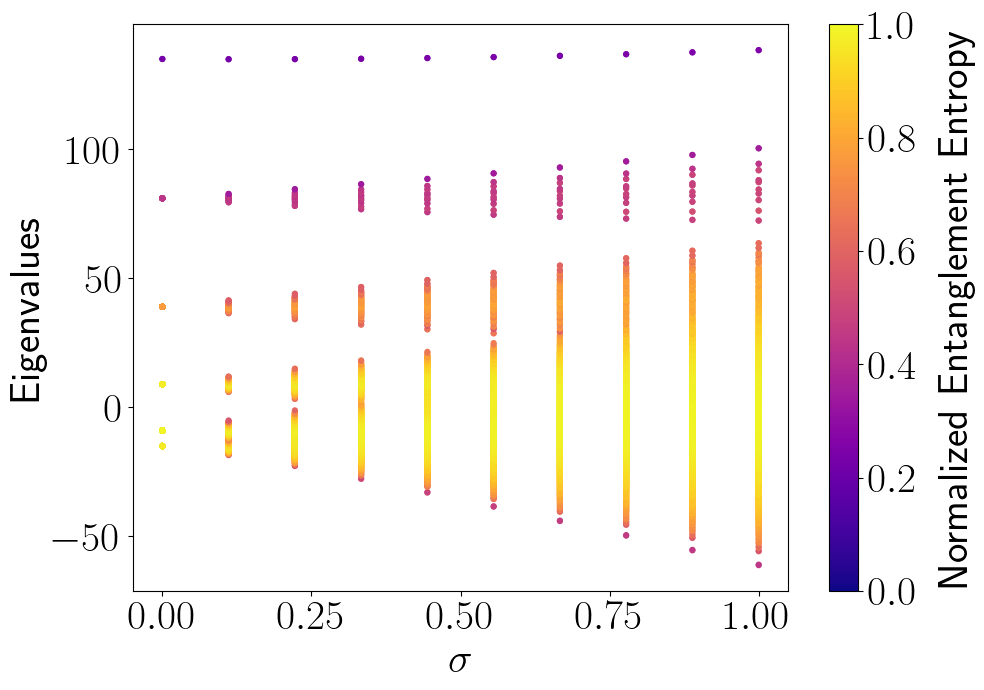

In [26]:
plt.figure(figsize=(10, 7))
num_sigma = len(sigma_lst)
dim = eigenvalues_vs_sigma.shape[1]
# Reshape normalized entropy to (num_sigma, dim)
ent_entropy_norm_reshaped = entanglement_entropy_normalized.reshape(num_sigma, dim)
scatter = plt.scatter(
     np.repeat(sigma_lst, dim),
     np.real(eigenvalues_vs_sigma.flatten()),
     c=entanglement_entropy_normalized,
     cmap='plasma',
     vmin = 0,
     vmax = 1,
     s=20,
     edgecolor='none'
)
plt.xlabel(r'$\sigma$')
plt.ylabel('Eigenvalues')
cbar = plt.colorbar(scatter)
cbar.set_label('Normalized Entanglement Entropy', labelpad = 15)
plt.tight_layout()
plt.show()

In [27]:
# # Load the sigma_lst from a particular b
# L = 9
# k = 4

# folder_name = f'spectrum_long_ranged_L_10_9_k_2_3_4_5_6_7'
# # path = '/Users/sasankadowarah/python_test_codes/k-local_hamiltonian/data/'+str(folder_name)+ '/'
# b = 139
# # os.chdir(path + "b" + str(b))
# # H_1_0 = load_npz(f'H_1_0_L_{L}_k_{k}_sigma_1.0.npz')

# path = f"/Users/sasankadowarah/python_test_codes/k-local_hamiltonian/data/spectrum_long_ranged_L_10_9_k_2_3_4_5_6_7/b{b}/"
# os.chdir(path)
# print(f"Current working directory: {os.getcwd()}")
# sigma_lst = np.linspace(0.0, 10.0, 160)  # Example sigma values
# sigma_lst

In [28]:
# iter_lst = [i for i in range(0, 160)]
# eigenvalues_lst = np.zeros((2**L, len(iter_lst)))
# entropy_lst = np.zeros((2**L, len(iter_lst)))
# for b in iter_lst:
#      path = f"/Users/sasankadowarah/python_test_codes/k-local_hamiltonian/data/spectrum_long_ranged_L_10_9_k_2_3_4_5_6_7/b{b}/"
#      os.chdir(path)
#      print(f"Processing for b = {b}")
#      sigma = sigma_lst[b]
#      # sigma = np.round(sigma, 5)
#      eigvals = load_npz(f'eigenvalues_L_{L}_k_{k}_mu_1.0_sigma_{sigma}.npz').toarray().flatten()
#      entropy = load_npz(f'entanglement_entropy_L_{L}_k_{k}_mu_1.0_sigma_{sigma}.npz').toarray().flatten()
#      eigenvalues_lst[:, b] = eigvals
#      entropy_lst[:, b] = entropy

In [29]:
# fig, ax = plt.subplots(figsize=(7, 5))
# page_val = page_entropy(L)  # make sure this is in nats
# entropy_norm = entropy_lst / page_val

# eigenvalues_lst_rescaled = eigenvalues_lst * math.comb(L, k) * 3 ** k

# for σ, eigs, Snorm in zip(sigma_lst, eigenvalues_lst_rescaled.T, entropy_norm.T):
#     ax.scatter(
#         σ*np.ones_like(eigs), eigs,
#         c=Snorm,
#         cmap='plasma',
#         vmin=0, vmax=1.0,
#         s=5, alpha=1.0,
#         edgecolor='none'
#     )

# plt.xlabel(r'$t$')
# plt.ylabel(r'Eigenvalues $\times 10^{9}$')
# norm = plt.Normalize(vmin=0, vmax=1.0)
# sm = plt.cm.ScalarMappable(cmap='plasma', norm=norm)
# sm.set_array([])  # Only needed for older matplotlib

# cbar = fig.colorbar(sm, ax=ax, pad=0.01)
# cbar.set_label(r'$S/S_{\rm Page}$')
# for spine in ax.spines.values():
#      spine.set_linewidth(1.5)
# ax.tick_params(axis = 'both', which = 'major', direction = 'out', length = 10, width = 1)  
# ax.set_yticks([-2e7, 0, 2.e7])
# ax.set_yticklabels([r'$-0.02$', r'$0$', r'$0.02$'])
# path = '/Users/sasankadowarah/python_test_codes/k-local_hamiltonian/'
# os.chdir(path)
# plt.savefig(f'long_ranged_spectrum_L_{L}_k_{k}.png', dpi=300, bbox_inches='tight')
# plt.show()